# MNIST Handwritten digits classification

![l](./pics/mnist.png)

In [ ]:
#-------- For obtaining the plots in the notebook -----#
from matplotlib import pyplot as plt
%matplotlib inline

# torch module spefic to com puter vision
from torchvision import datasets,transforms

In [9]:
#---------- Basic setup ------- #
DATASET_DIRECTORY = './mnist/'
SAVE_DIRECTORY    = './models/'


# Data

In [10]:
#------- Download training data, and set transformations to be applied -----#
mnist_train = datasets.MNIST(DATASET_DIRECTORY,
                             train=True,
                             transform=transforms.ToTensor(),
                             target_transform=None,
                             download=True)

mnist_test  = datasets.MNIST(DATASET_DIRECTORY,
                             train=False,
                             transform=transforms.ToTensor(),
                             target_transform = None,
                             download = True)

Processing...
Done!


In [31]:
# ---- Dimensions of dataset ---- # 
# ---- Training dataset ---- #
print("Training dataset dimensions")
print(mnist_train.train_data.size())

# ---- Test dataset ---- #
print("Test dataset dimensions")
print(mnist_test.test_data.size())

Training dataset dimensions
torch.Size([60000, 28, 28])
Test dataset dimensions
torch.Size([10000, 28, 28])


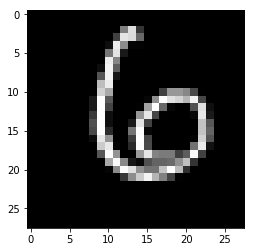

In [14]:
# --- Dislay some random image --- #
imgindex = 100
plt.imshow(mnist_test.test_data[imgindex].numpy(),cmap='gray')

# Simple network

![mnistnet](./pics/MNIST_CNN.png)

In [20]:
# ---- Build the architecture --- #

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


class Model(nn.Module):
    
    def __init__(self):
        
        super(Model,self).__init__()
        
        #--- The blocks are defined here ---#
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=0)
        self.mp1   = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.mp2   = nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc1   = nn.Linear(in_features=256,out_features=120)
        self.fc2   = nn.Linear(in_features=120,out_features=84)
        self.fc3  = nn.Linear(in_features=84,out_features=10)
  
        
    #--- Forward propagation ---#
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.mp1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.mp2(x)
        x = F.relu(x)
        
        x = x.view(-1,256)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.softmax(x)

        return x
    
model = Model()

if USE_CUDA:
    model = model.cuda()

print(model)

Model (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


#### Forward Pass

In [34]:
input = Variable(torch.randn(1, 1, 28, 28))
out = model(input)
print(out)

Variable containing:

Columns 0 to 5 
 7.2042e-04  5.2868e-06  1.9558e-05  3.1077e-01  2.3788e-10  1.5756e-01

Columns 6 to 9 
 7.9860e-08  2.8216e-03  5.2734e-01  7.6072e-04
[torch.FloatTensor of size 1x10]



#### Backward Pass

In [35]:
model.zero_grad()
out.backward(torch.randn(1, 10))

# Loss Function
In this example, we will use Classification Cross-Entropy loss and SGD with momentum.<br>
Cross Entropy loss is given as:- $L=-\sum_i y_i \log(p_i)$ and $p_i=\frac{\exp^{x_i}}{\sum_k \exp^{x_k}}$

There are many other loss functions such as MSELoss, L1Loss etc. Visit [here](http://pytorch.org/docs/master/nn.html#loss-functions) for other loss functions.

#### Stochastic Gradient Descent (SGD)
$$w_{n+1} = w_{n} - \eta \triangle$$
$$\triangle = 0.9\triangle + \frac{\partial L}{\partial w}$$

Although SGD is the most popular and basic optimizer that one should first try. There are many adaptive optimizers like Adagrad,Adadelta RMSProp and many more. Visit [here](http://pytorch.org/docs/master/optim.html) for other examples.

In [37]:
# ---- Settings for training ---- #
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Mini Batch training

In [38]:
# ----- Dataloades getting datasets ready for the network ---- #
BATCH_SIZE    = 128
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=BATCH_SIZE,shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=mnist_test,batch_size=BATCH_SIZE,shuffle=True)

# ---- Knowing about how data is stored in the loader ---- #
no_of_batches_train = len(train_loader)
no_of_batches_test  = len(test_loader)
print("Train data : ", no_of_batches_train, " batches of 128 samples each")
print("Test data : ",no_of_batches_test, " batches of 128 samples each")

Train data :  469  batches of 128 samples each
Test data :  79  batches of 128 samples each


In [39]:
# --- Training procedure ---- #

from tqdm import tqdm

running_loss = 0

# --- Iterate over epoch ---- #
for epoch in tqdm(range(EPOCH)):
    
    # ---- Iterate over each batch --- # 
    for iter_,data in enumerate(train_loader):
        inputs,labels = data
        
        # --- If CUDA is available move the tensor to GPU --- #
        if USE_CUDA:
            inputs,labels = inputs.cuda(),labels.cuda()            
        
        # --- To perform back propagation the tensors should be placed in Variable --- #
        inputs,labels = Variable(inputs),Variable(labels)
        
        # --- Setting the obtained gradients to zero --- #
        optimizer.zero_grad()
        
        # --- Forward propagation --- #
        outputs = model(inputs)
        
        # --- Backward propagation and optimization --- #
        # --- Finding the error --- # 
        loss = criterion(outputs,labels)
        running_loss += loss.data[0]
        
        #--- Backward propogate ---#
        loss.backward()
        optimizer.step()
    

100%|██████████| 25/25 [08:47<00:00, 21.11s/it]


In [28]:
#--- Parameter dimensions ---#
#--- This includes bias and weights ---#

params = list(model.parameters())

print("FC1 ---> Weights : ",params[0].size())
print("FC1 ---> Bias    : ",params[1].size())

print("FC2 ---> Weights : ",params[2].size())
print("FC2 ---> Bias    : ",params[3].size())

print("FC3 ---> Weights : ",params[4].size())
print("FC3 ---> Bias    : ",params[5].size())


FC1 ---> Weights :  torch.Size([6, 1, 5, 5])
FC1 ---> Bias    :  torch.Size([6])
FC2 ---> Weights :  torch.Size([16, 6, 5, 5])
FC2 ---> Bias    :  torch.Size([16])
FC3 ---> Weights :  torch.Size([120, 256])
FC3 ---> Bias    :  torch.Size([120])


In [29]:
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    labels = labels
    correct += (predicted == labels).sum()
    
print(total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

10000
Accuracy of the network on the 10000 test images: 81 %
